# Logistic Regression on TF-IDF using SpaCy
- Use SpaCy for tokenization and light pre-processing
- Ignore non-tweet features
- Pass tokens to sklearn TF-IDF
- Use TF-IDF features in sklearn LogisticRegressionCV

## Hashtag capture using SpaCy
https://github.com/explosion/spaCy/issues/2156  

In [2]:
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
spacy.prefer_gpu()

True

In [4]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.matcher import Matcher
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [5]:
# !python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")

In [6]:
# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [7]:
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [8]:
def spacy_tokenizer(string):
    doc = nlp(string)
#     return doc.text.split() # Disregards puncutation and contractions
#     return [token.orth_ for token in doc] # This should work better, but isn't perfect. This also splits hashtags hash symbol and the word tag
#     return [token.orth_ for token in doc if not token.is_punct | token.is_space]

    # Looks for hashtags
    matches = matcher(doc)
    spans = []
    for match_id, start, end in matches:
        spans.append(doc[start:end])


    for span in spans:
        span.merge()

#     print([t.text for t in doc])
#     return [t.text for t in doc if not t.is_punct | t.is_space]

#     return string.isupper(), string.islower(), [t.text for t in doc if not t.is_punct | t.is_space]
    return [t.text.lower() for t in doc if t not in stop_words and not t.is_punct | t.is_space]

In [9]:
def spacy_tokenizer_dataframe(df):
    """
    Works on a dataframe rather than directly on the strings
    Can't use this one for the sklearn pipeline
    """
    doc = nlp(df['text'])

    matches = matcher(doc)
    spans = []
    for match_id, start, end in matches:
        spans.append(doc[start:end])

    for span in spans:
        span.merge()

    df['upper'] = df['text'].isupper()
    df['lower'] = df['text'].islower()
    df['token_list'] = [t.text.lower() for t in doc if t not in stop_words and not t.is_punct | t.is_space]
    return df

In [10]:
# spacy_tokenizer("This is a   sentence!")

In [11]:
doc = nlp("Some text is going down the street")

In [12]:
doc

Some text is going down the street

In [13]:
dir(doc)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_bulk_merge',
 '_py_tokens',
 '_realloc',
 '_vector',
 '_vector_norm',
 'cats',
 'char_span',
 'count_by',
 'doc',
 'ents',
 'extend_tensor',
 'from_array',
 'from_bytes',
 'from_disk',
 'get_extension',
 'get_lca_matrix',
 'has_extension',
 'has_vector',
 'is_nered',
 'is_parsed',
 'is_sentenced',
 'is_tagged',
 'lang',
 'lang_',
 'mem',
 'merge',
 'noun_chunks',
 'noun_chunks_iterator',
 'print_tree',
 'remove_extension',
 'retokenize',
 'sentiment',
 'sents',
 'set_extension',
 'similarity',
 'tensor',
 'text',
 'text_with_ws',
 'to_array',
 'to_byte

In [14]:
# for el in doc.vocab:
#     print(el.text)

# for chunk in doc.noun_chunks:
#     print(chunk)

# for sent in doc.sents:
#     print(sent)

doc.text.split()

['Some', 'text', 'is', 'going', 'down', 'the', 'street']

In [15]:
train_df = pd.read_csv("data/train.csv")

In [16]:
train_df.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [17]:
train_df = train_df.head(30).apply(spacy_tokenizer, axis=1)

TypeError: Argument 'string' has incorrect type (expected str, got Series)

In [ ]:
for el in train_df.head(30)['token_list']:
    print(el)

In [18]:
matcher = Matcher(nlp.vocab)
matcher.add('HASHTAG', None, [{'ORTH': '#'}, {'IS_ASCII': True}])

doc = nlp("this is an #example of an awesome tweet with #manyhashtags #amazing")
matches = matcher(doc)
spans = []
for match_id, start, end in matches:
    spans.append(doc[start:end])
    
    
for span in spans:
    span.merge()

print([t.text for t in doc])

['this', 'is', 'an', '#example', 'of', 'an', 'awesome', 'tweet', 'with', '#manyhashtags', '#amazing']


In [19]:
spans

[#example, #manyhashtags, #amazing]

In [20]:
tfidf = TfidfVectorizer(tokenizer = spacy_tokenizer)
# x = v.fit_transform(df['sent'])

In [21]:
x = tfidf.fit_transform(train_df['text'].head(30))

In [22]:
x.todense()[0]

matrix([[0.        , 0.        , 0.        , 0.        , 0.29865656,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.26628554, 0.29865656, 0.        ,
         0.        , 0.        , 0.26628554, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.29865656, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['target'], test_size=0.3, random_state=42)

# classifier = LogisticRegression()

# # Create pipeline using Bag of Words
# pipe = Pipeline([
#                 ('vectorizer', tfidf),
#                  ('classifier', classifier)])

In [24]:
# classifier = LogisticRegressionCV(cv=5, random_state=42, n_jobs=-1).fit(train_df['text'], train_df['target'])
classifier = LogisticRegressionCV(cv=5, random_state=42, n_jobs=-1)
# Create pipeline using Bag of Words
pipe = Pipeline([
                ('vectorizer', tfidf),
                 ('classifier', classifier)])

In [25]:
%%time
# model generation
pipe.fit(train_df['text'],train_df['target'])

CPU times: user 2min 45s, sys: 1.19 s, total: 2min 46s
Wall time: 2min 48s


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<function spacy_tokenizer at 0x7f5420d2e950>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=5,
                                      dual=Fal

In [26]:
dir(pipe)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_required_parameters',
 '_set_params',
 '_transform',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'memory',
 'named_steps',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_para

In [27]:
pipe._final_estimator

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [28]:
pipe.decision_function

<function sklearn.pipeline.Pipeline.decision_function(self, X)>

In [29]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['target'], random_state=42)

In [30]:
%%time
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.8550420168067226
Logistic Regression Precision: 0.9282296650717703
Logistic Regression Recall: 0.7158671586715867
CPU times: user 39.2 s, sys: 344 ms, total: 39.6 s
Wall time: 39.8 s


# Wow, 85% cross-validation accuracy with almost no feature engineering

In [31]:
import matplotlib.pyplot as plt

Confusion matrix, without normalization
[[1046   45]
 [ 231  582]]
Normalized confusion matrix
[[0.96 0.04]
 [0.28 0.72]]


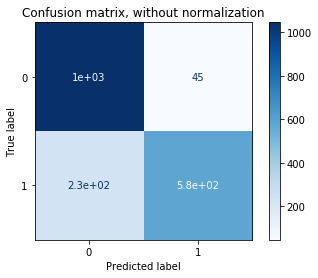

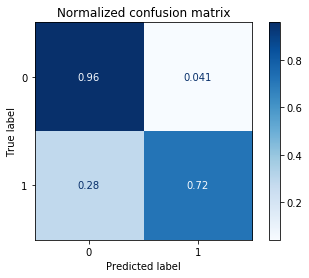

In [32]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(pipe,
                                         X_test, 
                                         y_test,
#                                  display_labels=class_names,
                                 display_labels=pipe.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize
                                        )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Our main issue is identifying false negatives

# Get filtered list of false negative tweets

In [45]:
predictions = pipe.predict(X_test)
predictions

array([0, 0, 1, ..., 1, 0, 1])

In [72]:
false_negatives = X_test.copy()
false_negatives.head()

2644    So you have a new weapon that can cause un-ima...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132     Aftershock back to school kick off was great. ...
6845    in response to trauma Children of Addicts deve...
Name: text, dtype: object

In [73]:
false_negatives = false_negatives.reset_index()
false_negatives.head()

,index,text
0,2644,So you have a new weapon that can cause un-ima...
1,2227,The f$&amp;@ing things I do for #GISHWHES Just...
2,5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
3,132,Aftershock back to school kick off was great. ...
4,6845,in response to trauma Children of Addicts deve...


In [74]:
false_negatives['predictions'] = predictions
false_negatives['actual'] = y_test.values
false_negatives.head()

,index,text,predictions,actual
0,2644,So you have a new weapon that can cause un-ima...,0,1
1,2227,The f$&amp;@ing things I do for #GISHWHES Just...,0,0
2,5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,1
3,132,Aftershock back to school kick off was great. ...,0,0
4,6845,in response to trauma Children of Addicts deve...,0,0


In [75]:
false_negatives.tail()

,index,text,predictions,actual
1899,5209,Very glad that you got obliterated in X Men Fi...,0,0
1900,387,Mourning notices for stabbing arson victims st...,1,1
1901,4848,Mass murderer Che Guevara greeting a woman in ...,1,1
1902,1032,Womens Flower Printed Shoulder Handbags Cross ...,0,0
1903,7195,@abcnews A nuclear bomb is a terrible weapon!!,1,1


In [76]:
# Get false negatives
false_neg_only = false_negatives.loc[(false_negatives['predictions'] == 0) & (false_negatives['actual'] == 1)]

In [77]:
false_neg_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 1888
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        231 non-null    int64 
 1   text         231 non-null    object
 2   predictions  231 non-null    int64 
 3   actual       231 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.0+ KB


In [78]:
false_neg_only['text']

0       So you have a new weapon that can cause un-ima...
6       my favorite lady came to our volunteer meeting...
7       @brianroemmele UX fail of EMV - people want to...
20      Nepal earthquake 3 months on: Women fear abuse...
34      @Kinder_Morgan can'twon't tell @cityofkamloops...
                              ...                        
1830    The second part which focuses on the survivors...
1854    White family (supposedly representing America'...
1866      #Battlefield 1942 forgotten hope secret weapons
1887    NOT.. Ready for this heat wave .. I don't want...
1888    #?x?: :and to counter acts such as the burning...
Name: text, Length: 231, dtype: object

In [81]:
false_neg_only.loc[1866, 'text']

'#Battlefield 1942 forgotten hope secret weapons'

In [84]:
false_neg_only.to_csv("false_negative_tweets.csv", index=False)

In [85]:
train_df.loc[7244]

id                                                 10374
keyword                                          weapons
location                               ??? ?????????????
text        I will adamantly opposed to nuclear weapons.
target                                                 1
Name: 7244, dtype: object

# Manual look at the false negative tweets show a bunch that appear incorrectly labeled. 